# Altitude dependence of prompt muon flux

In [65]:
from MCEq.core import MCEqRun
import crflux.models as pm

import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import trapezoid
import astropy.units as u

In [54]:
run = MCEqRun('SIBYLL23C', (pm.HillasGaisser2012, 'H3a'), 0)

MCEqRun::set_interaction_model(): SIBYLL23C
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_primary_model(): HillasGaisser2012 H3a


In [55]:
run.solve()

In [56]:
mag = 3
prompt_muon_flux = (run.get_solution('pr_mu+', mag) + 
             run.get_solution('pr_mu-', mag))
conv_muon_flux = (run.get_solution('conv_mu+', mag) + 
             run.get_solution('conv_mu-', mag))

In [67]:
flux_unit = 1/(u.cm**2 * u.s * u.sr * u.GeV)
flux_unit

<Quantity 1. 1 / (GeV s sr cm2)>

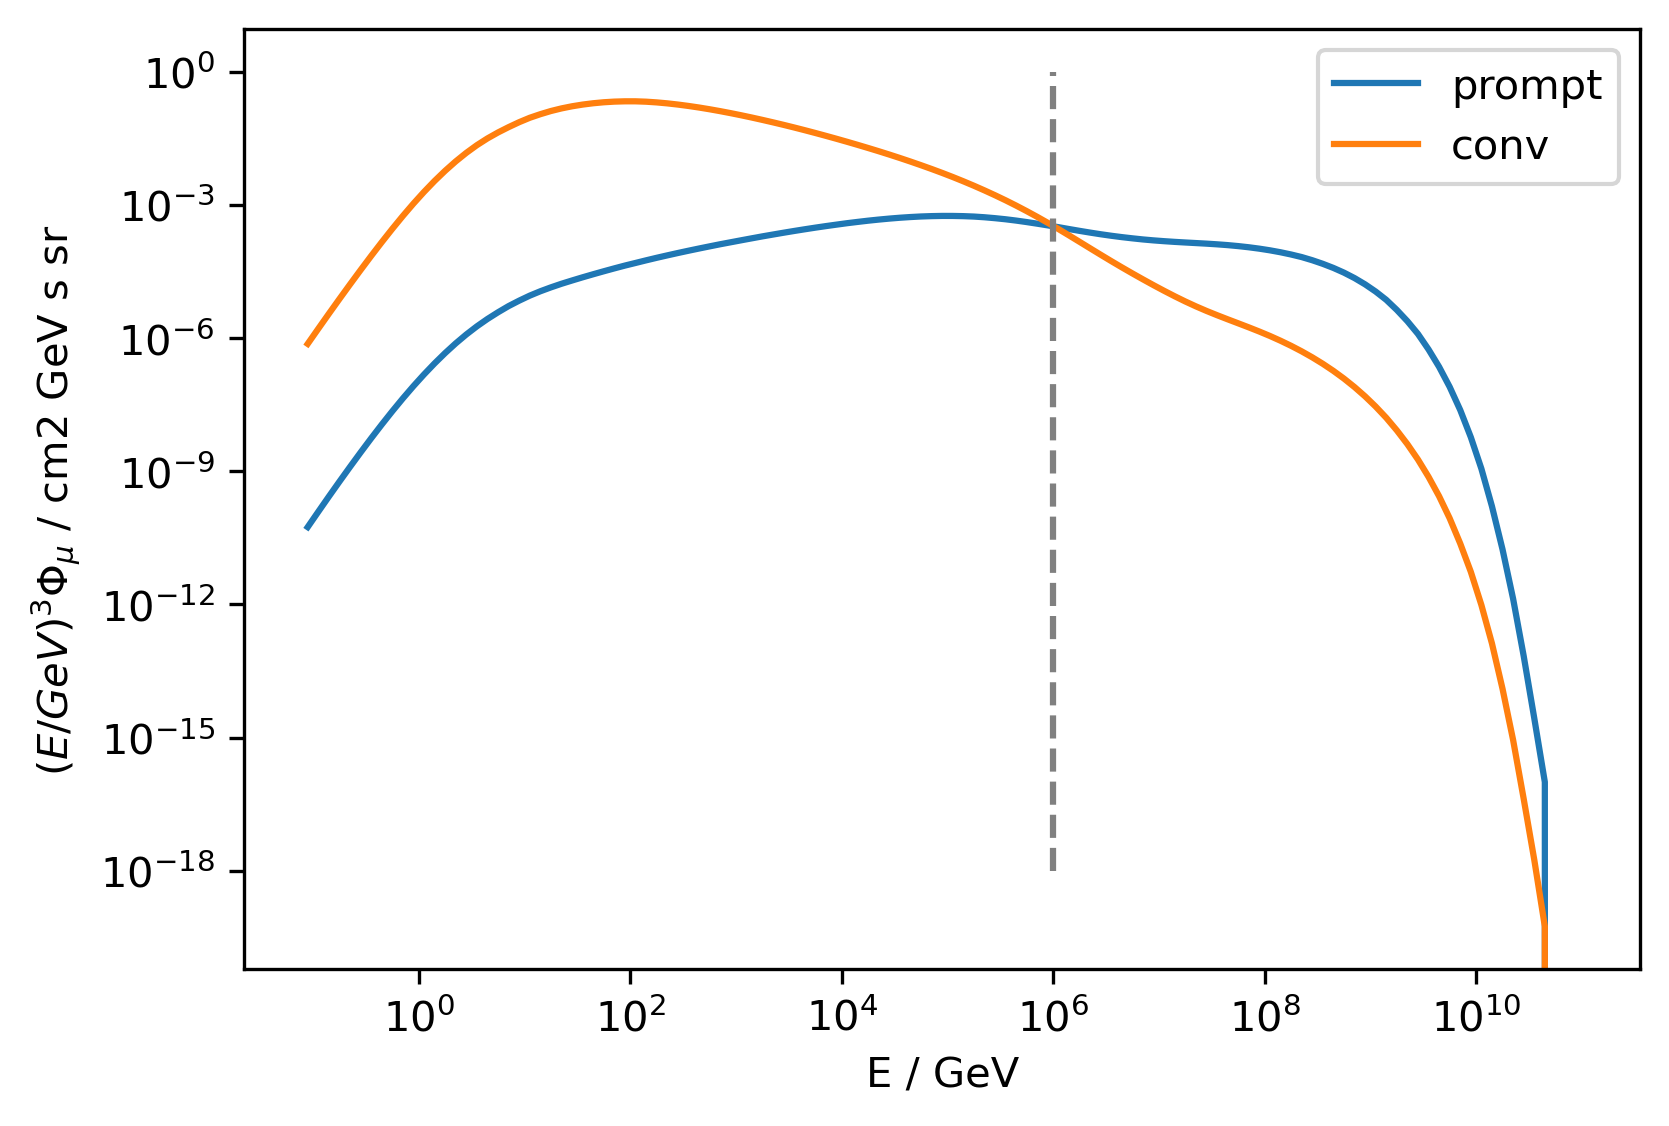

In [104]:
fig = plt.figure(figsize=(5.45, 3.64),
    dpi=300,
    constrained_layout=True)
plt.plot(run.e_grid, prompt_muon_flux, label='prompt')
plt.plot(run.e_grid, conv_muon_flux, label='conv')
plt.vlines(1e6, 1e-18, 1, ls='--', color='gray')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(rf'$(E/GeV)^3 \Phi_\mu$ / {flux_unit.unit**-1}')
plt.xlabel('E / GeV')
plt.legend()

$\frac{d}{dh}\Big( \int \text{flux}(E,h)\, dE \Big)$

In [58]:
n = 100
h_grid = np.linspace(50 * 1e3 * 1e2, 0, n) # altitudes from 50 to 0 km (in cm)
X_grid = run.density_model.h2X(h_grid)

run.solve(int_grid=X_grid)

In [79]:
def integrate_e(flux, energies, energy_bound=0*u.GeV):
    mask = energies > energy_bound
    return trapezoid(flux[mask], energies[mask])

In [80]:
energy_bound = 1e6 * u.GeV
pr_mu_grid = [integrate_e(run.get_solution('pr_mu+', grid_idx=idx)*flux_unit + run.get_solution('pr_mu-', grid_idx=idx)*flux_unit, run.e_grid*u.GeV, energy_bound) for idx in range(n)]
conv_mu_grid = [integrate_e(run.get_solution('conv_mu+', grid_idx=idx)*flux_unit + run.get_solution('conv_mu-', grid_idx=idx)*flux_unit, run.e_grid*u.GeV, energy_bound) for idx in range(n)]

In [81]:
pr_mu_grid_dh = -np.gradient(pr_mu_grid, h_grid*u.cm)
conv_mu_grid_dh = -np.gradient(conv_mu_grid, h_grid*u.cm)

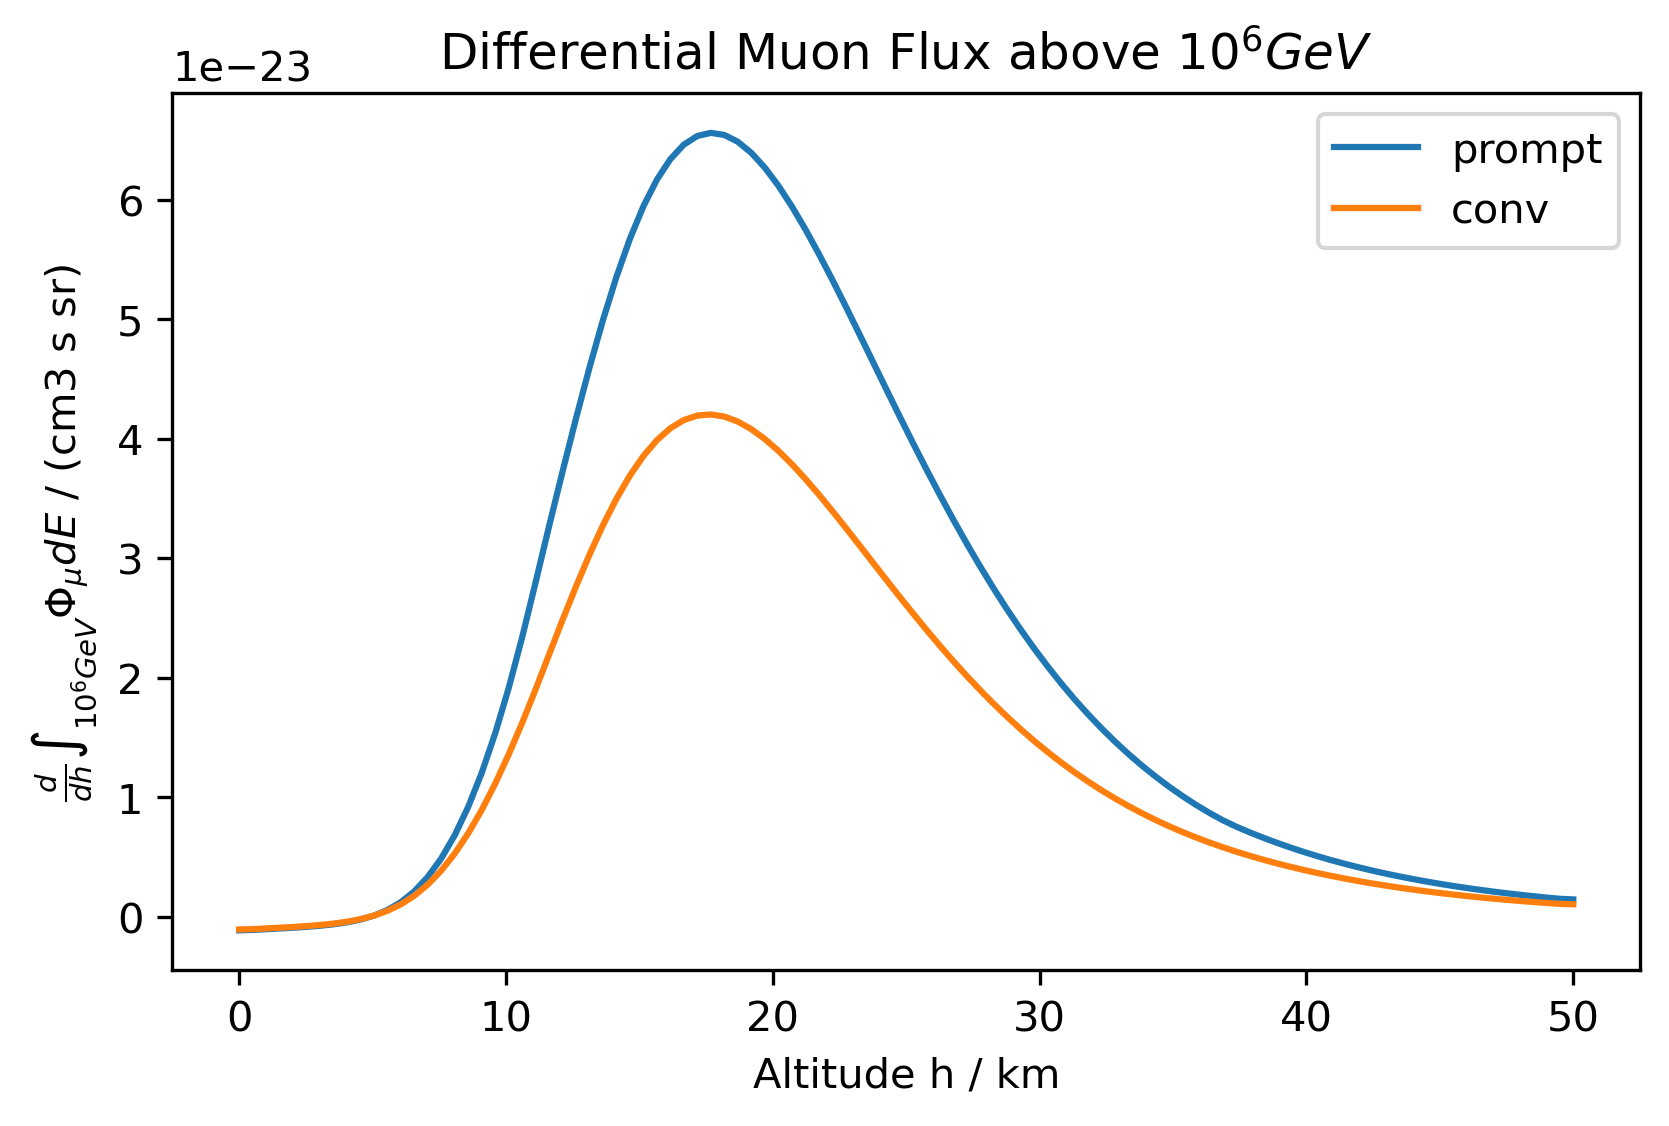

In [98]:
fig = plt.figure(figsize=(5.45, 3.64),
    dpi=300,
    constrained_layout=True)
plt.plot(h_grid/(1e2 * 1e3), pr_mu_grid_dh, label='prompt')
plt.plot(h_grid/(1e2 * 1e3), conv_mu_grid_dh, label='conv')
plt.yscale('linear')
plt.xscale('linear')
plt.xlabel('Altitude h / km')
plt.ylabel(rf'$\frac{{d}}{{dh}}\int_{{10^6 GeV}} \Phi_\mu dE$ / ({pr_mu_grid_dh.unit**-1})')
plt.title(r'Differential Muon Flux above $10^6 GeV$')
plt.legend()